#### TopN Simple Wines Recommender System From A User Code With Tensorflow
#### Rogério Xavier de Azambuja (rogerio.xavier@farroupilha.ifrs.edu.br)
#### Dataset X-Wines from https://github.com/rogerioxavier/X-Wines

In [1]:
# Opening required packages for processing
import pandas as pd
import numpy as np
from typing import Dict, Text
import tensorflow as tf
import tensorflow_recommenders as tfrs
# Opening required packages to show output
from matplotlib import pyplot as plt
import cv2 as cv

In [2]:
# Opening X-Wines dataset
wines   = pd.read_csv("XWines_100K_wines.csv", low_memory=False, encoding="utf-8", memory_map=True)
ratings = pd.read_csv("XWines_21M_ratings.csv", low_memory=False, encoding="utf-8", memory_map=True)
len(wines), len(ratings)

(100646, 21013536)

In [3]:
print("Total wines:", wines.WineID.nunique(), "from", wines.Code.nunique() ,"different countries")
print("Total users:", ratings.UserID.nunique(), "who rated the wines")
print(f"             in the period between {ratings.Date.min()} and {ratings.Date.max()}")
print("Total ratings:", len(ratings), f"5-stars on wine vintages since {ratings.Vintage.min()}, including non-vintage 'N.V.'")

Total wines: 100646 from 62 different countries
Total users: 1056079 who rated the wines
             in the period between 2012-01-03 08:20:53 and 2021-12-31 23:59:56
Total ratings: 21013536 5-stars on wine vintages since 1950, including non-vintage 'N.V.'


In [4]:
# A first segmentation because the dataset is too big
code = 'BR'
country = 'Brazil'

In [5]:
winesCode = wines.loc[ wines.Code==code ]
print(winesCode.WineID.nunique(), f"wines from the country {country}({code}) ")

1539 wines from the country Brazil(BR) 


In [6]:
# Data preparation for wine recommendation
ratingsCountry = pd.merge(ratings, winesCode.WineID, how="inner", on=['WineID'])
ratingsCountry = ratingsCountry.sort_values(['Date'], ascending=False)
ratingsCountry = ratingsCountry.drop_duplicates(subset=['UserID', 'WineID'], keep='first')
print(len(ratingsCountry), f"unique last user ratings about {code} wines")

301916 unique last user ratings about BR wines


In [7]:
# Cut-off point for training on the most relevant data
mostRatingsWines = ratingsCountry.groupby(['WineID'], as_index=False)['Rating'].count()
mostRatingsWines.rename(columns={'Rating':'Frequency'}, inplace=True)
mostRatingsWines = mostRatingsWines.loc[ mostRatingsWines.Frequency>5 ] # optional minimum value
print(len(mostRatingsWines), "most ratings wines")

mostRatingsUsers = ratingsCountry.groupby('UserID', as_index=False)['Rating'].count()
mostRatingsUsers.rename(columns={'Rating':'Frequency'}, inplace=True)
mostRatingsUsers = mostRatingsUsers.loc[ mostRatingsUsers.Frequency>5 ]  # optional minimum value
print(len(mostRatingsUsers), "most ratings users")

1488 most ratings wines
10116 most ratings users


In [8]:
# Data segmentation for collaborative filtering
collabRatings = pd.merge(ratingsCountry,  mostRatingsWines.WineID, how="inner", on=['WineID'])
print(collabRatings.WineID.nunique(), "most ratings wines")
collabRatings = pd.merge(collabRatings, mostRatingsUsers.UserID, how="inner", on=['UserID'])
print(collabRatings.UserID.nunique(), "most ratings users")

collabWines = pd.merge(mostRatingsWines, winesCode[['WineID', 'WineName']], on='WineID')
collabWines = collabWines[['WineID', 'WineName']].reset_index(drop=True)
collabRatings = collabRatings[['UserID', 'WineID']].reset_index(drop=True)
print(len(winesCode),'to', len(collabWines), 'useful wines for collaborative filtering')
print(len(ratingsCountry),'to', len(collabRatings), 'useful ratings for collaborative filtering')

1488 most ratings wines
10116 most ratings users
1539 to 1488 useful wines for collaborative filtering
301916 to 149989 useful ratings for collaborative filtering


In [9]:
# Runtime variables
seed = 123
test_percentage  = 10
train_percentage = 100-test_percentage
embedding_dimension = 32 # 64 ?
metrics_batchsize =  8 * 3 # size x velocit training ?
train_batchsize   = 64 * 3
test_batchsize    =  32 * 3
learning_rate = 0.5 # 0.5 ?
epochs = 10
index_batchsize = 100

In [10]:
# Data preparation for machine learning
collabRatings = collabRatings[['UserID','WineID']]
unique_users_ids = collabRatings['UserID'].unique()
unique_wines_ids = collabRatings['WineID'].unique()

view_size  = len(collabRatings)
train_size = round(view_size/100*train_percentage)
test_size  = view_size-train_size

print("Data sample size:", view_size, "   Relationship training/testing:", train_size, test_size)

Data sample size: 149989    Relationship training/testing: 134990 14999


In [11]:
# Tensors using tensorflow
tfRatings = tf.data.Dataset.from_tensor_slices(dict(collabRatings))
tfWines   = tf.data.Dataset.from_tensor_slices(unique_wines_ids)

In [12]:
# Data separation for training and testing model 
tf.random.set_seed(seed)

tfRatings_shuffled = tfRatings.shuffle(view_size, seed=seed, reshuffle_each_iteration=False)

train = tfRatings_shuffled.take(train_size)
test  = tfRatings_shuffled.skip(train_size).take(test_size)

len(train), len(test)

(134990, 14999)

In [13]:
# Simple model layers definition
user_model = tf.keras.Sequential([
  tf.keras.layers.IntegerLookup(vocabulary=unique_users_ids, mask_token=None),
  tf.keras.layers.Embedding(input_dim=len(unique_users_ids) + 1, output_dim=embedding_dimension)])
wine_model = tf.keras.Sequential([
  tf.keras.layers.IntegerLookup(vocabulary=unique_wines_ids, mask_token=None),
  tf.keras.layers.Embedding(input_dim=len(unique_wines_ids) + 1, output_dim=embedding_dimension)])
metrics = tfrs.metrics.FactorizedTopK(candidates=tfWines.batch(metrics_batchsize).map(wine_model))
task = tfrs.tasks.Retrieval(metrics=metrics)

In [14]:
class XWines_Model(tfrs.Model):
    def __init__(self, user_model, wine_model):
        super().__init__()
        self.wine_model: tf.keras.Model = wine_model
        self.user_model: tf.keras.Model = user_model
        self.task: tf.keras.layers.Layer = task
    def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
        wine_embeddings = self.wine_model(features["WineID"])
        user_embeddings = self.user_model(features["UserID"])
        return self.task(user_embeddings, wine_embeddings)

In [15]:
# XWines model building using basic parameters
model = XWines_Model(user_model, wine_model)
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=learning_rate))

In [16]:
# network training using basic parameters
cached_train = train.shuffle(view_size).batch(train_batchsize).cache()
history = model.fit(cached_train, epochs=epochs)

Epoch 1/10
704/704 [==============================] - 76s 105ms/step - factorized_top_k/top_1_categorical_accuracy: 2.2224e-05 - factorized_top_k/top_5_categorical_accuracy: 0.0016 - factorized_top_k/top_10_categorical_accuracy: 0.0049 - factorized_top_k/top_50_categorical_accuracy: 0.0352 - factorized_top_k/top_100_categorical_accuracy: 0.0779 - loss: 1035.5462 - regularization_loss: 0.0000e+00 - total_loss: 1035.5462
Epoch 2/10
704/704 [==============================] - 83s 118ms/step - factorized_top_k/top_1_categorical_accuracy: 4.0003e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0244 - factorized_top_k/top_10_categorical_accuracy: 0.0500 - factorized_top_k/top_50_categorical_accuracy: 0.1835 - factorized_top_k/top_100_categorical_accuracy: 0.2946 - loss: 900.8183 - regularization_loss: 0.0000e+00 - total_loss: 900.8183
Epoch 3/10
704/704 [==============================] - 83s 118ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0016 - factorized_top_k/top_5_categori

<AxesSubplot:xlabel='epochs', ylabel='%'>

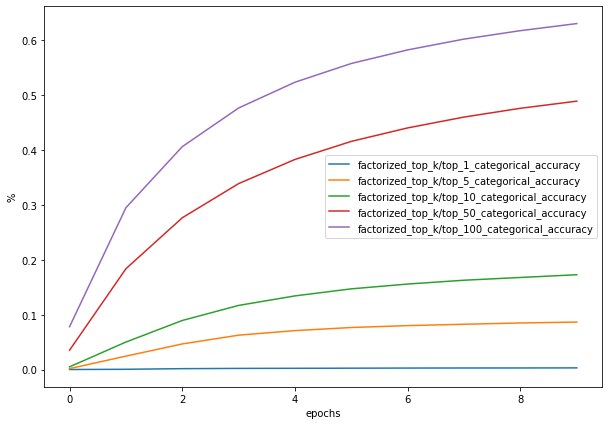

In [17]:
# plot model training
pd.DataFrame(history.history).iloc[:, 0:5].plot(figsize=(10,7), xlabel="epochs", ylabel="%")

<AxesSubplot:xlabel='epochs', ylabel='amount'>

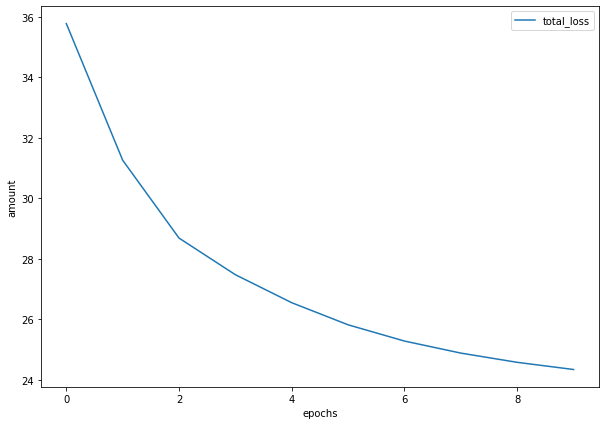

In [18]:
# plot model training
pd.DataFrame(history.history).iloc[:, 7:8].plot(figsize=(10,7), xlabel="epochs", ylabel="amount")

In [19]:
# model testing using basic parameters
cached_test = test.batch(test_batchsize).cache()
model.evaluate(cached_test, return_dict=True)

157/157 [==============================] - 19s 119ms/step - factorized_top_k/top_1_categorical_accuracy: 3.3336e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0046 - factorized_top_k/top_10_categorical_accuracy: 0.0126 - factorized_top_k/top_50_categorical_accuracy: 0.0861 - factorized_top_k/top_100_categorical_accuracy: 0.1758 - loss: 564.5352 - regularization_loss: 0.0000e+00 - total_loss: 564.5352


{'factorized_top_k/top_1_categorical_accuracy': 0.0003333555650897324,
 'factorized_top_k/top_5_categorical_accuracy': 0.004600306507200003,
 'factorized_top_k/top_10_categorical_accuracy': 0.01260084006935358,
 'factorized_top_k/top_50_categorical_accuracy': 0.08613907545804977,
 'factorized_top_k/top_100_categorical_accuracy': 0.17581172287464142,
 'loss': 97.22271728515625,
 'regularization_loss': 0,
 'total_loss': 97.22271728515625}

In [20]:
# Create a model that takes in raw query features, and
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
# recommends wines out of the entire wines dataset.
index.index_from_dataset(
    tf.data.Dataset.zip((tfWines.batch(index_batchsize),
    tfWines.batch(index_batchsize).map(model.wine_model)))
)
# TopN simple wines recommender from a user position
def recommenderTF(nUser=0, nRecommendation=10):
    scores, winesIDs = index(tf.constant([nUser]))
    print(f"Recommendations for user {nUser}:")
    recList = []
    for (s, n) in zip(scores[0][:nRecommendation], winesIDs[0][:nRecommendation]):
        wineID = int(tf.get_static_value(n))
        wine = winesCode.loc[ winesCode.WineID == wineID ][['WineID', 'WineName']].values[0]
        recList.append({'WineID':wine[0],'WineName':wine[1], \
                        'Similarity':round(tf.get_static_value(s),5)})
    recList.sort(key=lambda i: i['Similarity'], reverse=True)
    return (pd.DataFrame(recList))

In [21]:
# TopN simple wines recommender from a user position
def recommenderTF(nUser=0, nRecommendation=10):
    scores, winesIDs = index(tf.constant([nUser]))
    print(f"Recommendations for user {nUser}:")
    recList = []
    for (s, n) in zip(scores[0][:nRecommendation], winesIDs[0][:nRecommendation]):
        wineID = int(tf.get_static_value(n))
        wine = winesCode.loc[ winesCode.WineID == wineID ][['WineID', 'WineName']].values[0]
        recList.append({'WineID':wine[0], 'WineName':wine[1], 'Similarity':round( tf.get_static_value(s), 5)})
    recList.sort(key=lambda i: i['Similarity'], reverse=True)
    return (pd.DataFrame(recList))

def show10wines(df=pd.DataFrame()):
    if len(df) == 0:
        print("Bad input to show wines")
        return 
    else:
        if len(df)==1:
            plt.figure(figsize=(25, 10))
            titlesize = 25
        else:
            plt.figure(figsize=(50, 20))
            titlesize = 40
        i = 1
        for (wineID, wineName) in (zip(df.WineID[:10], df.WineName[:10])):
            plt.subplot(2,5,i), plt.imshow( cv.imread(f"images/{wineID}.jpeg",1) )
            plt.title("\n"+wineName, fontsize=titlesize)
            plt.xticks([]),plt.yticks([])
            i+=1
        plt.show()       
        return

Recommendations for user 58:


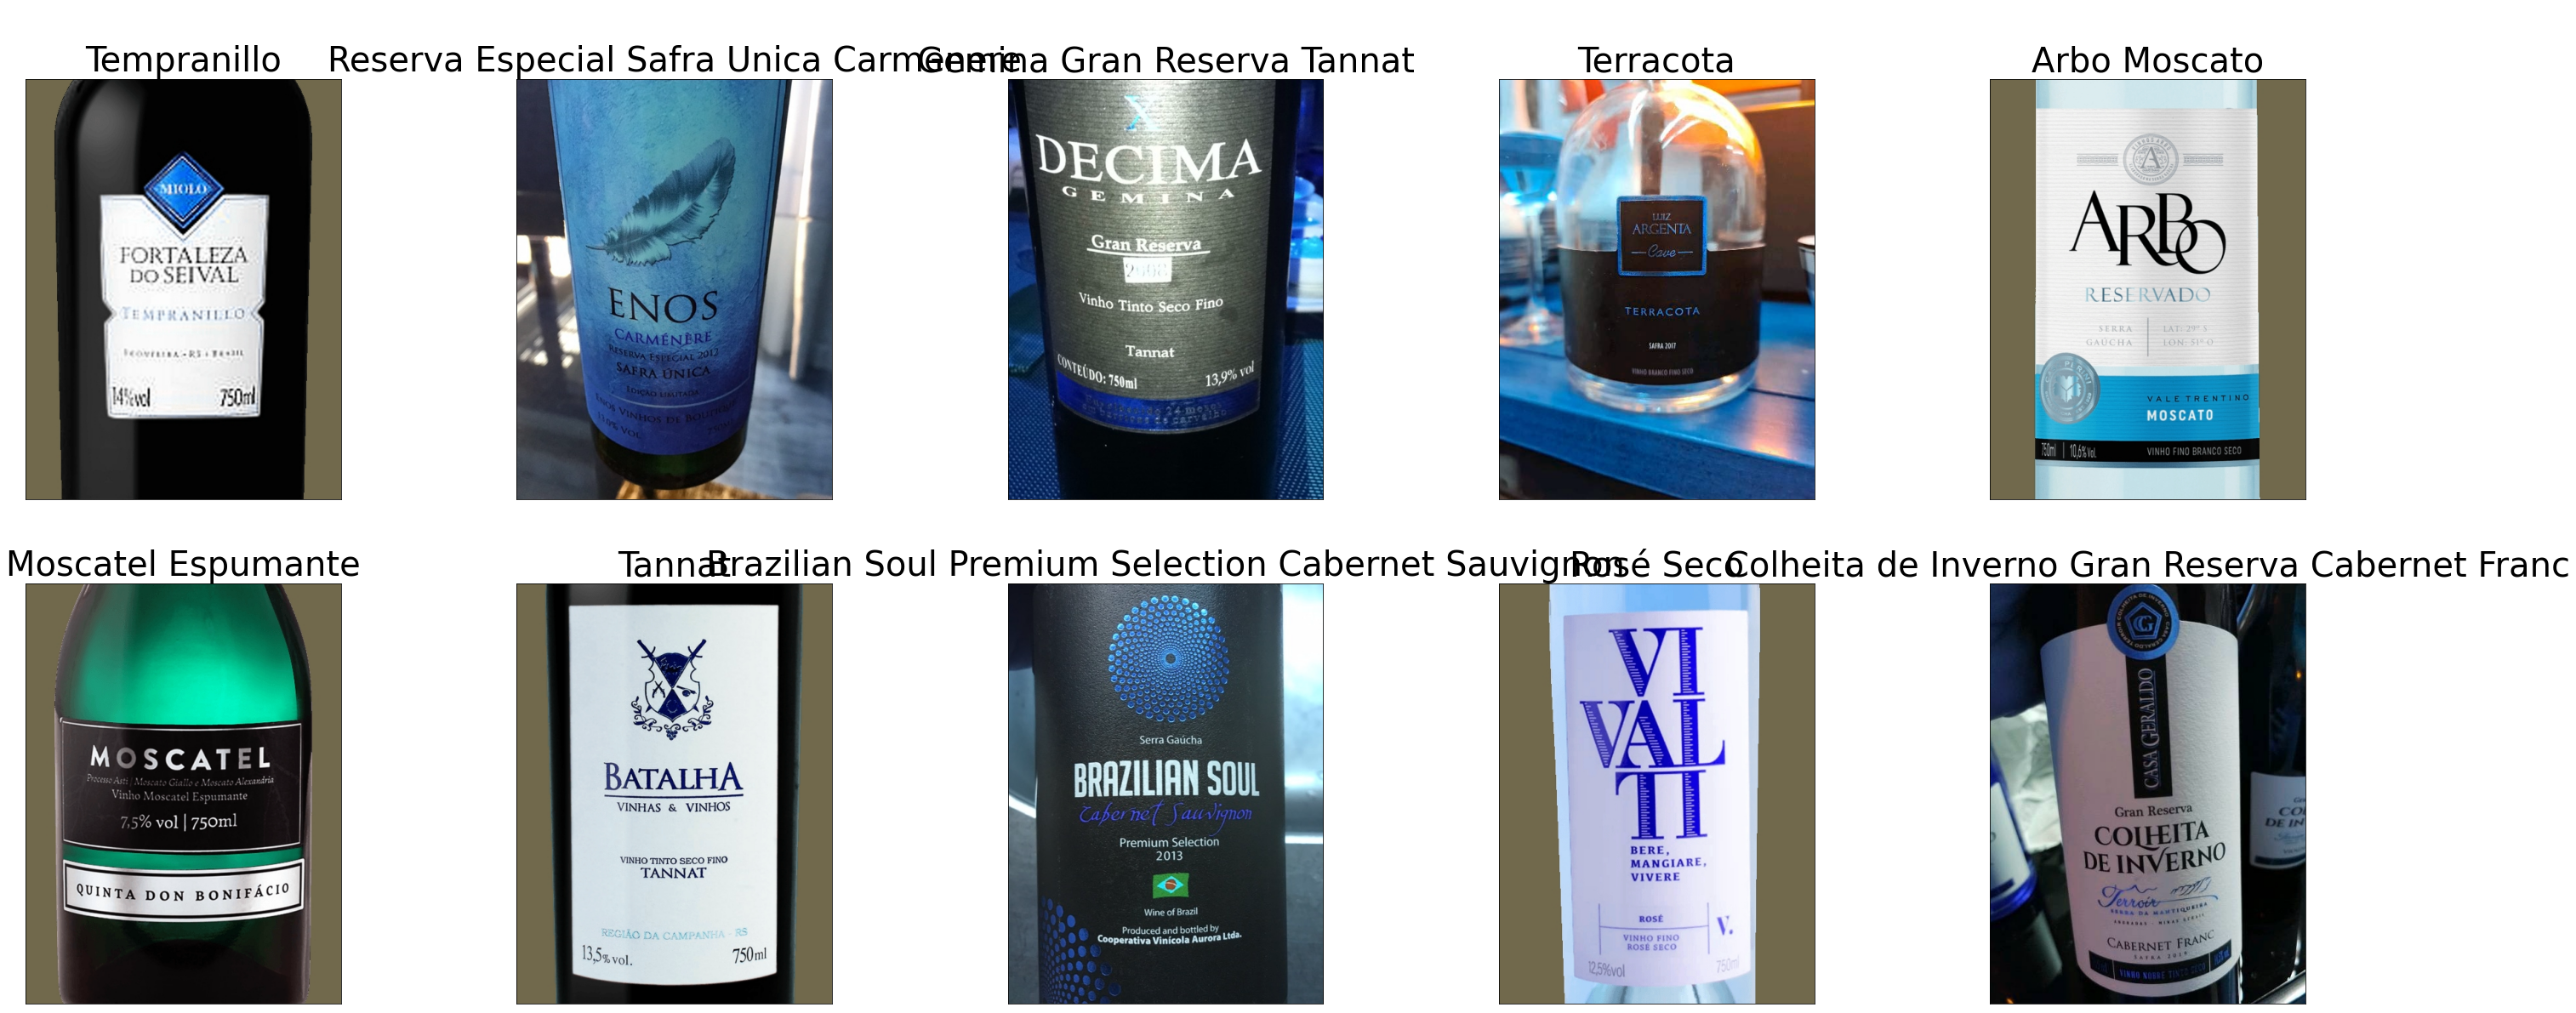

In [22]:
# Get wine recommendations from a user position
nUser = 58; topN = 10
recommendedWines = recommenderTF(nUser, topN)
show10wines(recommendedWines)

In [23]:
recommendedWines

,WineID,WineName,Similarity
0,100937,Tempranillo,0.33592
1,101229,Reserva Especial Safra Unica Carmenere,0.30798
2,100866,Gemina Gran Reserva Tannat,0.30287
3,101377,Terracota,0.29753
4,100505,Arbo Moscato,0.29551
5,101021,Moscatel Espumante,0.29177
6,100564,Tannat,0.28296
7,101063,Brazilian Soul Premium Selection...,0.28094
8,100846,Rosé Seco,0.27541
9,101142,Colheita de Inverno Gran Reserva...,0.26808
